## Diplomski rad - Klasificiranje LEGO kocaka koristeći neuronske mreže

Rad se izvodi koristeći PlaidML za AMD GPU preko Keras-a

In [1]:
import os
os.environ["KERAS_BACKEND"] = "plaidml.keras.backend"

Promijene vezane za PlaidML se mogu izvesti sa pokretanjem `plaidml-setup` u powershell-u

Sve sljedece linije ce se spominjati na Engleskom jeziku zbog jednostavnosti i istoznacnosti sa programskim ködom na engleskom jeziku

In [2]:
import numpy as np
import keras
from matplotlib import pyplot as plt
import cv2

from tensorflow.keras.applications.vgg16 import VGG16

Using plaidml.keras.backend backend.
C:\Users\Anto\anaconda3\envs\lego\lib\site-packages\tensorflow\python\framework\dtypes.py:526: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
C:\Users\Anto\anaconda3\envs\lego\lib\site-packages\tensorflow\python\framework\dtypes.py:527: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
C:\Users\Anto\anaconda3\envs\lego\lib\site-packages\tensorflow\python\framework\dtypes.py:528: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
C:\Users\Anto\anaconda3\envs\lego\lib\site

In [3]:
dataset_path = "../../LEGO_brick_images_v1/"
dataset_output = "./output"

In [4]:
#if you want you can run this once, but some randomness can be good
import splitfolders
splitfolders.ratio(dataset_path, output=dataset_output, ratio=(.7, .3))

os.listdir(dataset_output)

['train', 'val']

In [4]:
from keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.preprocessing import image
from tensorflow.keras.applications.vgg16 import preprocess_input #required to format input

""" train_datagen = ImageDataGenerator(
    rescale=1./255,
    shear_range=0.2,
    zoom_range=0.2,
    width_shift_range=0.2,
    height_shift_range=0.2
) """
train_datagen = ImageDataGenerator(
    zoom_range=0.2,
    preprocessing_function=preprocess_input
)
validation_datagen = ImageDataGenerator(
    preprocessing_function=preprocess_input
)

train_generator = train_datagen.flow_from_directory(os.path.join(dataset_output,'train'), target_size=(200,200), shuffle=True, class_mode="categorical")
validation_generator = validation_datagen.flow_from_directory(os.path.join(dataset_output, 'val'), target_size=(200,200), shuffle=True, class_mode='categorical')


print(len(train_generator.class_indices))

Found 2785 images belonging to 10 classes.
Found 1194 images belonging to 10 classes.
10


In [9]:
from keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from keras.models import Model, Sequential
vgg16_model = VGG16(weights='imagenet', include_top=False, input_shape=(200,200,3))

#freeze layers
for layer in vgg16_model.layers:
    layer.trainable = False

#TODO: make work work
model = vgg16_model.output
model = Flatten()(model)
model = Dense(128, activation="relu")(model)
model = Dropout(0.4)(model)
model = Dense(64, activation="relu")(model)
model = Dense(len(train_generator.class_indices), activation="softmax")(model)

model.summary()

TypeError: 'Tensor' object is not callable

In [40]:
from keras.callbacks import ModelCheckpoint,EarlyStopping,TensorBoard,CSVLogger,ReduceLROnPlateau

best_model_weights = './base.model'
checkpoint = ModelCheckpoint(
    best_model_weights,
    monitor='val_loss',
    verbose=1,
    save_best_only=True,
    mode='min',
    save_weights_only=False,
    period=1
)
earlystop = EarlyStopping(
    monitor='val_loss',
    min_delta=0.001,
    patience=5,
    verbose=1,
    mode='auto'
)
tensorboard = TensorBoard(
    log_dir = './logs',
    histogram_freq=0,
    batch_size=16,
    write_graph=True,
    write_grads=True,
    write_images=False,
)

csvlogger = CSVLogger(
    filename= "training_csv.log",
    separator = ",",
    append = False
)


reduce = ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.2,
    patience=5,
    verbose=1, 
    mode='auto',
    cooldown=1 
)

callbacks = [checkpoint,tensorboard,csvlogger,reduce]

C:\Users\Anto\anaconda3\envs\lego\lib\site-packages\keras\callbacks.py:756: UserWarning: You are not using the TensorFlow backend. write_graph was set to False
  warnings.warn('You are not using the TensorFlow backend. '


In [41]:
from keras.optimizers import SGD

opt = SGD(lr=1e-3, nesterov="true")
model.compile(
    loss='categorical_crossentropy',
    optimizer=opt,
    metrics=['accuracy']
)

history = model.fit_generator(
    train_generator, 
    steps_per_epoch  = 100, 
    validation_data  = validation_generator,
    validation_steps = 100,
    epochs = 100, 
    verbose = 1,
    callbacks=callbacks
)

json_model = model.to_json()

with open("./model/lego.json", "w") as json_file:
    json_file.write(json_model)

model.save_weights("./model/lego_weights.h5")

Epoch 1/100
100/100 [==============================] - 74s 739ms/step - loss: 2.2466 - acc: 0.1388 - val_loss: 2.1383 - val_acc: 0.3061

Epoch 00001: val_loss improved from inf to 2.13829, saving model to ./base.model
Epoch 2/100
100/100 [==============================] - 41s 414ms/step - loss: 2.1667 - acc: 0.1893 - val_loss: 2.0730 - val_acc: 0.2757

Epoch 00002: val_loss improved from 2.13829 to 2.07297, saving model to ./base.model
Epoch 3/100
100/100 [==============================] - 42s 415ms/step - loss: 2.1485 - acc: 0.1862 - val_loss: 2.0122 - val_acc: 0.3093

Epoch 00003: val_loss improved from 2.07297 to 2.01223, saving model to ./base.model
Epoch 4/100
100/100 [==============================] - 41s 410ms/step - loss: 2.1213 - acc: 0.1941 - val_loss: 1.9752 - val_acc: 0.4024

Epoch 00004: val_loss improved from 2.01223 to 1.97516, saving model to ./base.model
Epoch 5/100
100/100 [==============================] - 42s 415ms/step - loss: 2.0615 - acc: 0.2222 - val_loss: 1.909

KeyboardInterrupt: 

In [42]:
def show_final_history(history):
    fig, ax = plt.subplots(1, 2, figsize=(15,5))
    ax[0].set_title('loss')
    ax[0].plot(history.epoch, history.history["loss"], label="Train loss")
    ax[0].plot(history.epoch, history.history["val_loss"], label="Validation loss")
    ax[1].set_title('acc')
    ax[1].plot(history.epoch, history.history["acc"], label="Train acc")
    ax[1].plot(history.epoch, history.history["val_acc"], label="Validation acc")
    ax[0].legend()
    ax[1].legend()

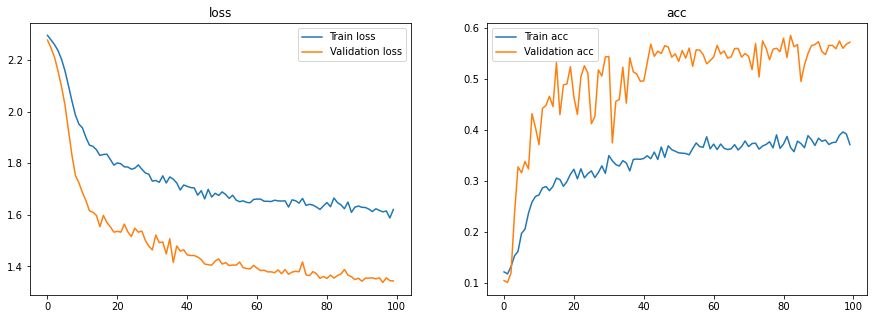

In [43]:
show_final_history(history)

We can try and test the model on random new images

In [31]:
#image_path = "../../LEGO_brick_images_v1/2357 Brick corner 1x2x2/201706171206-0001.png"
image_path = "../../LEGO_brick_images_v1/3004 Brick 1x2/0003.png"
image = cv2.imread(image_path)

from numpy import array
json_file = open("./model/lego.json", "r")
json_model = json_file.read()
json_file.close()

loaded_model = keras.models.model_from_json(json_model)
loaded_model.load_weights("./model/lego_weights.h5")

loaded_model.summary()
image = np.expand_dims(image, axis=0)
prediction = loaded_model.predict_classes(image)

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_10 (Conv2D)           (None, 198, 198, 32)      896       
_________________________________________________________________
max_pooling2d_9 (MaxPooling2 (None, 99, 99, 32)        0         
_________________________________________________________________
conv2d_11 (Conv2D)           (None, 97, 97, 32)        9248      
_________________________________________________________________
max_pooling2d_10 (MaxPooling (None, 48, 48, 32)        0         
_________________________________________________________________
flatten_5 (Flatten)          (None, 73728)             0         
_________________________________________________________________
dense_12 (Dense)             (None, 64)                4718656   
_________________________________________________________________
dropout_5 (Dropout)          (None, 64)                0         
__________

In [32]:
prediction[0]

4

Since the classes are sorted alphabetically, an item from the third folder should give us a number `2` from `prediction[0]`.